In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

path = "/content/rehab_data.csv"

rehab = pd.read_csv(path)
rehab.head(10)

,ID,program,physical_health,psychological_wellbeing
0,1,Program A,64.40,72.95
1,2,Program A,67.70,69.39
2,3,Program A,85.59,66.91
3,4,Program A,70.71,59.98
4,5,Program A,71.29,75.89
5,6,Program A,87.15,60.20
6,7,Program A,74.61,82.50
7,8,Program A,57.35,77.26
8,9,Program A,63.13,63.11
9,10,Program A,65.54,56.79


In [433]:
rehab.shape

(90, 4)

In [434]:
rehab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       90 non-null     int64  
 1   program                  90 non-null     object 
 2   physical_health          90 non-null     float64
 3   psychological_wellbeing  90 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ KB


1. **Check assumptions. MANOVA makes the following assumptions about the data:**

* Adequate sample size
* Independence of the observations
* Absence of univariate or multivariate outliers
* Multivariate normality
* Linearity
* Homogeneity of variances
* Homogeneity of variance-covariance matrices

In [435]:
# Fitting the model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.multivariate.manova import MANOVA

manova = MANOVA.from_formula('physical_health + psychological_wellbeing ~ program', data = rehab)
manovaResult = manova.mv_test()

manovaResult.results['program']['stat']

,Value,Num DF,Den DF,F Value,Pr > F
Wilks' lambda,0.726094,4,172.0,7.462889,0.000014
Pillai's trace,0.280455,4.0,174.0,7.094779,0.000026
Hotelling-Lawley trace,0.368214,4,102.169014,7.886873,0.000014
Roy's greatest root,0.341829,2,87,14.869545,0.000003


In [436]:
# Residuals

olsPhyiscal = smf.ols('physical_health ~ program', data = rehab).fit()
olsPsychological = smf.ols('psychological_wellbeing ~ program', data = rehab).fit()

residualsPhysical = olsPhyiscal.resid
residualsPsychological = olsPsychological.resid

rehab['residualPhysical'] = residualsPhysical
rehab['residualPsychological'] = residualsPsychological

In [437]:
# Outlier

for col in ['physical_health', 'psychological_wellbeing']:
  rehab[f'{col}ZScore'] = (rehab[col] - rehab[col].mean()) / rehab[col].std()

  # Identify outliers (typically Z-Score > 3 or < -3)
  outlierZScore = rehab[np.abs(rehab[f'{col}ZScore']) > 3]
  print(f"Outliers for {col}:")
  print(outlierZScore)
  print()

Outliers for physical_health:
Empty DataFrame
Columns: [ID, program, physical_health, psychological_wellbeing, residualPhysical, residualPsychological, physical_healthZScore]
Index: []

Outliers for psychological_wellbeing:
    ID    program  physical_health  psychological_wellbeing  residualPhysical  \
73  74  Program C            69.36                   104.41           -11.006   

    residualPsychological  physical_healthZScore  \
73                 30.872              -0.533188   

    psychological_wellbeingZScore  
73                       3.695286  



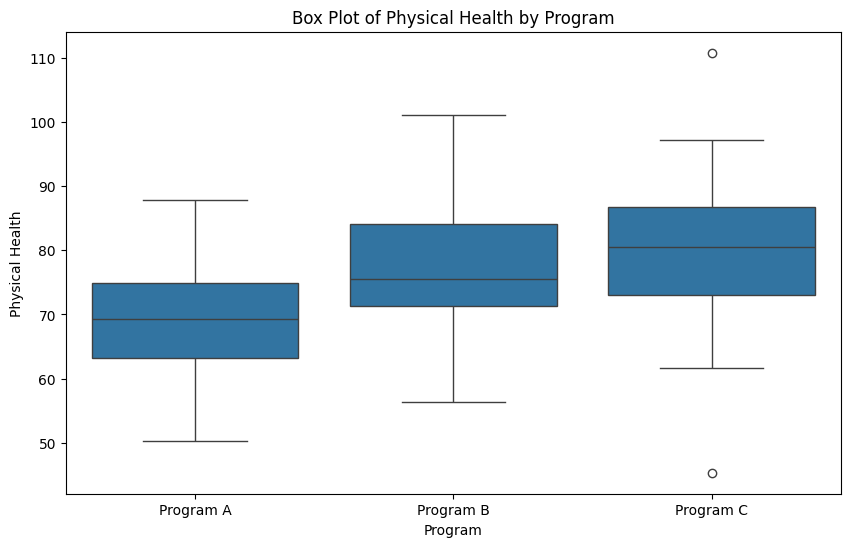

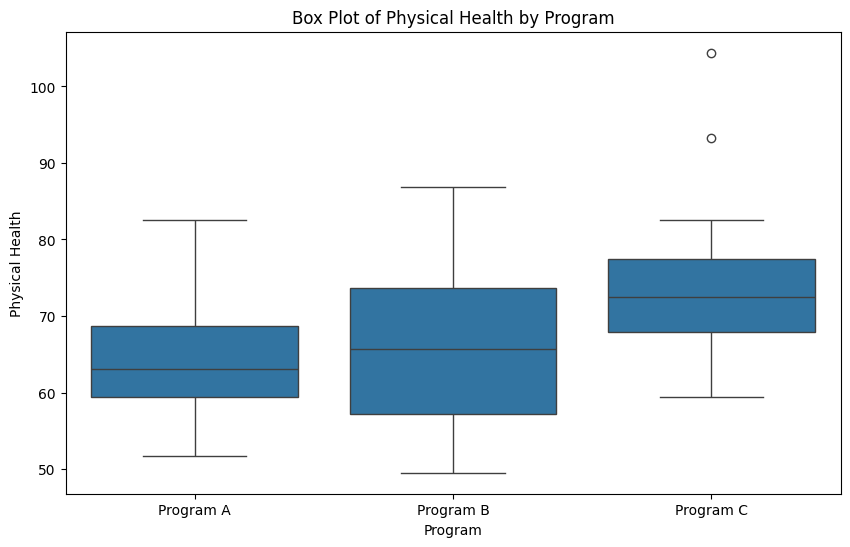

In [438]:
import seaborn as sns

# Create a box plot for physical health by program
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'program', y = 'physical_health', data = rehab)
plt.title('Box Plot of Physical Health by Program')
plt.xlabel('Program')
plt.ylabel('Physical Health')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x = 'program', y = 'psychological_wellbeing', data = rehab)
plt.title('Box Plot of Physical Health by Program')
plt.xlabel('Program')
plt.ylabel('Physical Health')
plt.show()

Shapiro-Wilk test for physical_health: 0.6654
Shapiro-Wilk test for psychological_wellbeing: 0.0113


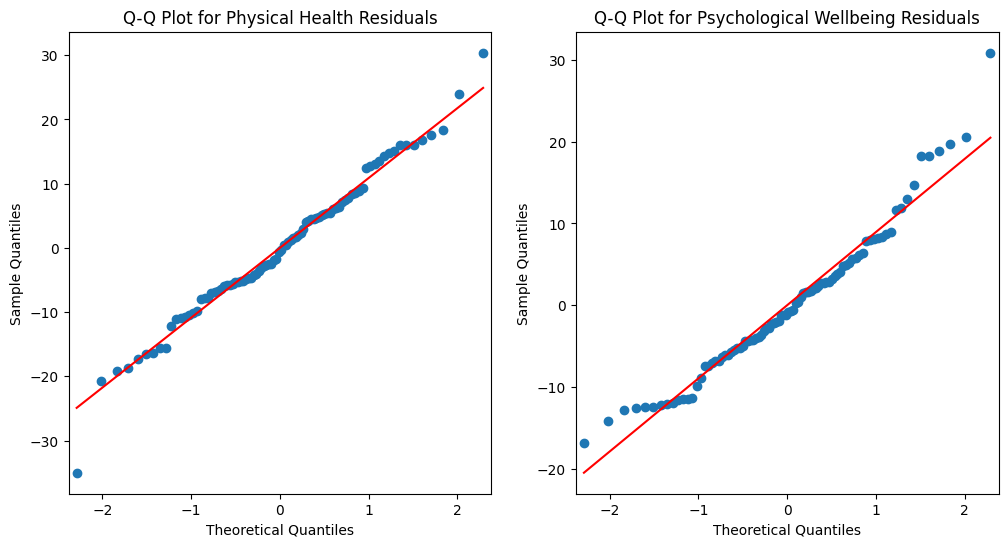

In [439]:
# Normality

shapiroPhysical = stats.shapiro(residualsPhysical)
shapiroPsychological = stats.shapiro(residualsPsychological)

print(f'Shapiro-Wilk test for physical_health: {round(shapiroPhysical[1], 4)}')
print(f'Shapiro-Wilk test for psychological_wellbeing: {round(shapiroPsychological[1], 4)}')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sm.qqplot(residualsPhysical, line = 's', ax =axs[0])
axs[0].set_title('Q-Q Plot for Physical Health Residuals')

sm.qqplot(residualsPsychological, line = 's', ax = axs[1])
axs[1].set_title('Q-Q Plot for Psychological Wellbeing Residuals')

plt.show()

Since `rehab['pscyhological_wellbeing']` is not normally distributed, let as perform log transformation.

In [440]:
rehab['logPhysical'] = (np.log(rehab['physical_health'] + 1))
rehab['logPsychological'] = (np.log(rehab['psychological_wellbeing'] + 1))
rehab.head()

,ID,program,physical_health,psychological_wellbeing,residualPhysical,residualPsychological,physical_healthZScore,psychological_wellbeingZScore,logPhysical,logPsychological
0,1,Program A,64.40,72.95,-5.129,8.699667,-0.951735,0.498419,4.180522,4.303389
1,2,Program A,67.70,69.39,-1.829,5.139667,-0.673266,0.136663,4.229749,4.254051
2,3,Program A,85.59,66.91,16.061,2.659667,0.836372,-0.115346,4.461184,4.218183
3,4,Program A,70.71,59.98,1.181,-4.270333,-0.419269,-0.819551,4.272630,4.110546
4,5,Program A,71.29,75.89,1.761,11.639667,-0.370326,0.797173,4.280686,4.342376


Shapiro-Wilk test for physical_health: 0.097
Shapiro-Wilk test for psychological_wellbeing: 0.3594


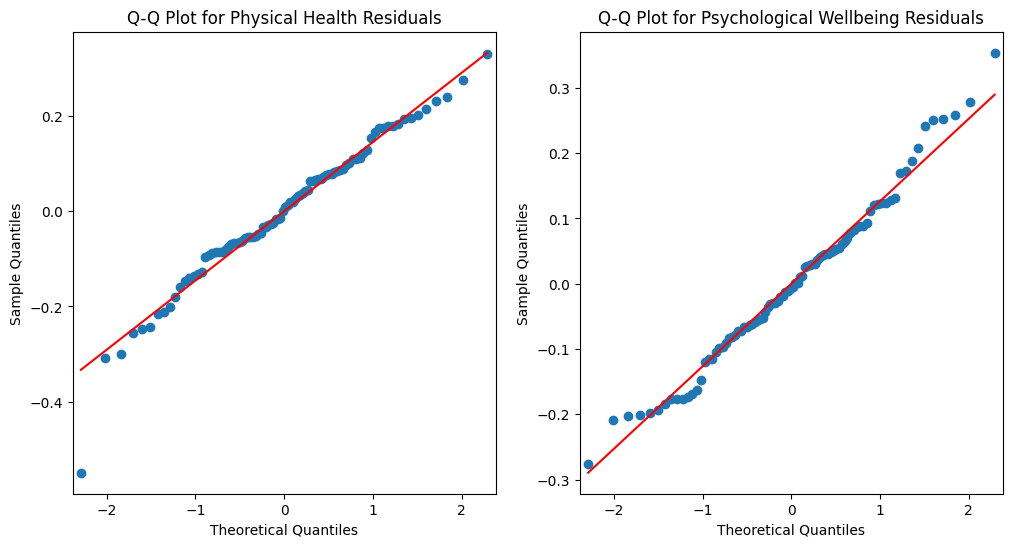

In [441]:
olsPhyiscal = smf.ols('logPhysical ~ program', data = rehab).fit()
olsPsychological = smf.ols('logPsychological ~ program', data = rehab).fit()

residualsPhysical = olsPhyiscal.resid
residualsPsychological = olsPsychological.resid

shapiroPhysical = stats.shapiro(residualsPhysical)
shapiroPsychological = stats.shapiro(residualsPsychological)

print(f'Shapiro-Wilk test for physical_health: {round(shapiroPhysical[1], 4)}')
print(f'Shapiro-Wilk test for psychological_wellbeing: {round(shapiroPsychological[1], 4)}')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sm.qqplot(residualsPhysical, line = 's', ax =axs[0])
axs[0].set_title('Q-Q Plot for Physical Health Residuals')

sm.qqplot(residualsPsychological, line = 's', ax = axs[1])
axs[1].set_title('Q-Q Plot for Psychological Wellbeing Residuals')

plt.show()

They are now both in Normal Distribution.

In [442]:
# Linearity

logColumns = ['logPhysical', 'logPsychological']

correlationMatrix = rehab[logColumns].corr()
print(f"The correlation matrix for {logColumns} is:")
print(correlationMatrix)
print()

The correlation matrix for ['logPhysical', 'logPsychological'] is:
                  logPhysical  logPsychological
logPhysical          1.000000          0.170207
logPsychological     0.170207          1.000000



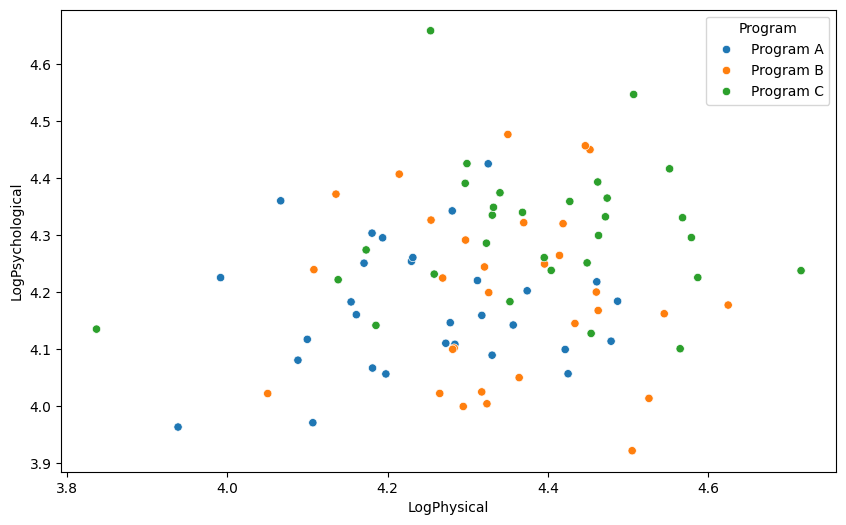

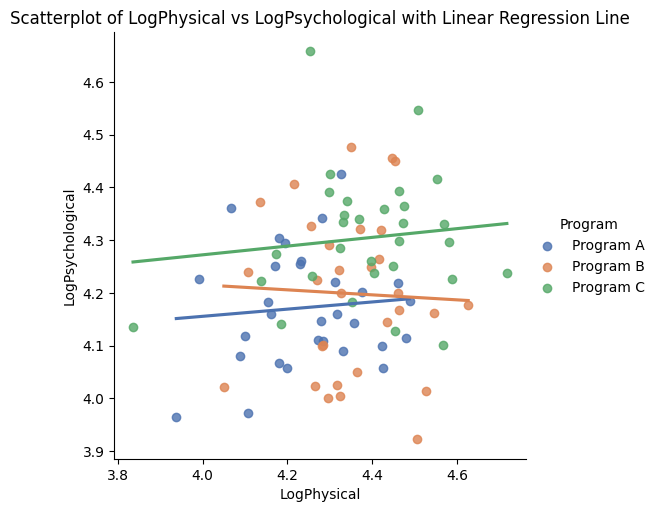

In [443]:
import seaborn as sns

data = pd.DataFrame({
    'LogPhysical': rehab['logPhysical'],
    'LogPsychological': rehab['logPsychological'],
    'Program': rehab['program']
})

# Create the scatterplot with seaborn
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'LogPhysical',
                y = 'LogPsychological',
                data = data,
                hue = 'Program',
                color = 'blue')

# Add a linear regression line
sns.lmplot(x = 'LogPhysical',
           y = 'LogPsychological',
           hue = 'Program',
           data = data,
           palette = 'deep',
           ci = None)

# Customizing the plot
plt.xlabel('LogPhysical')
plt.ylabel('LogPsychological')
plt.title('Scatterplot of LogPhysical vs LogPsychological with Linear Regression Line')
plt.show()


As supported by the `pd.corr()` and the scatter plot, there is a weak positive correlation between `rehab['logPhysical']` and `rehab['logPyschological']`. The Linearity must be weaken due to the oppoisng factor of `Group B`.

In [444]:
# Homogeneity of Variances

rehab['residualLogPhysical'] = residualsPhysical
rehab['residualLogPsychological'] = residualsPsychological

from scipy.stats import levene

for col in ['residualLogPhysical', 'residualLogPsychological']:
  programA = rehab[rehab['program'] == 'Program A']
  programB = rehab[rehab['program'] == 'Program B']
  programC = rehab[rehab['program'] == 'Program C']

  programA = programA[col]
  programB = programB[col]
  programC = programC[col]

  stats, p_value = levene(programA, programB, programC)

  print(f"The p-value for homogeneity of variances is {round(p_value, 4)}")

The p-value for homogeneity of variances is 0.5637
The p-value for homogeneity of variances is 0.117


The values for both Levene's are greater than $0.05$, implying their homogeneity of residuals' variances across groups.

In [445]:
# Homogeneity of variance-covariance matrices

#!pip install pingouin
import pingouin as pg

boxMData = rehab[['program', 'logPhysical', 'logPsychological']]

boxMTest = pg.box_m(data = boxMData,
                    dvs = [ 'logPhysical', 'logPsychological'],
                    group = 'program')

# Print the results
print(f"p-value: {boxMTest['pval']}")

p-value: box    0.412774
Name: pval, dtype: float64


The assumption for homogeneity of covaraince is met as the p-value is greater than $0.05$ at $0.412774$.

2. **Fit MANOVA model using Pillai's test**

In [446]:
manova = MANOVA.from_formula('logPhysical + logPsychological ~ program',
                             data = rehab)
manovaResult = manova.mv_test()

pillaiResult = manovaResult.results['program']['stat']
pillaiValue = pillaiResult.loc['Pillai\'s trace', 'Value']
pillaiFValue = pillaiResult.loc['Pillai\'s trace', 'F Value']
pillaiPValue = pillaiResult.loc['Pillai\'s trace', 'Pr > F']

# Print Pillai's Trace results
print("Pillai's Trace Test Results:")
print(f"Value: {pillaiValue}")
print(f"F-Value: {pillaiFValue}")
print(f"P-Value: {pillaiPValue}")

Pillai's Trace Test Results:
Value: 0.2751240524966376
F-Value: 6.93840986125781
P-Value: 3.320429523653426e-05


The dataset garnered a p-value of almost 0 with 3.3204e-05. This indicates that there are significant differences among the group of the dataset. It also indicates that the programs done have significant effects to the measured values, meaning the program chosen matters to the physical health and psychological wellbeing of the participants.

In [447]:
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform ANOVA for each dependent variable
DVs = ['logPhysical', 'logPsychological']

for var in DVs:
    print(f"\n### ANOVA for {var} ###")
    model = ols(f"{var} ~ program",
                data = rehab).fit()
    anova_table = sm.stats.anova_lm(model, typ = 2)
    print(anova_table)

    # Check if the ANOVA is significant (p-value < 0.05)
    if anova_table["PR(>F)"][0] < 0.05:
        print(f"\n### Tukey's HSD for {var} ###")
        tukey = pairwise_tukeyhsd(endog = rehab[var], groups = rehab['program'], alpha = 0.05)
        print(tukey)
    else:
        print(f"No significant group differences detected for {var}.")
    print("\n")


### ANOVA for logPhysical ###
            sum_sq    df         F    PR(>F)
program   0.313390   2.0  7.168202  0.001313
Residual  1.901798  87.0       NaN       NaN

### Tukey's HSD for logPhysical ###


<ipython-input-447-1af9dab3fff0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table["PR(>F)"][0] < 0.05:


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
Program A Program B   0.1039 0.0212  0.0129 0.1949   True
Program A Program C    0.139 0.0013   0.048   0.23   True
Program B Program C   0.0351 0.6297 -0.0559 0.1261  False
---------------------------------------------------------



### ANOVA for logPsychological ###
            sum_sq    df         F    PR(>F)
program   0.291737   2.0  8.827678  0.000323
Residual  1.437585  87.0       NaN       NaN

### Tukey's HSD for logPsychological ###


<ipython-input-447-1af9dab3fff0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table["PR(>F)"][0] < 0.05:


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
Program A Program B   0.0262 0.7101 -0.0529 0.1054  False
Program A Program C   0.1317 0.0004  0.0526 0.2109   True
Program B Program C   0.1055 0.0058  0.0264 0.1847   True
---------------------------------------------------------




The dataset shows that the differences are driven primarily by Program A as it holds significant differences from Program B and Program C.

Meanwhile, the main driver for `psychological_wellbeing` is Program C as it has meaningful differences from Program A and B.

# **As the data set has undergone analysis, it was revealed that Program A and Program C are strong drivers of effect, A as positive and C as negative as shown with the scatterplot earlier. It may be recommended that the researchers will enforce and improve the implementation of Program A while discouraging or enhancing Program C.**